In [1]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 
import matplotlib.patches as patches # Active zones
import matplotlib.path as mplPath
from mpl_toolkits.mplot3d import Axes3D
# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook 

In [2]:
## My scripts
from LandmarkMask import vertices_circles
from LandmarkMask import vertices_squares
from LandmarkMask import vertices_triangles
from LandmarkMask import circle_around_food

In [3]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/TrackFiles/DecisionPoints/CueNew/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/TrackFiles/DecisionPoints/CueNew/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/TrackFiles/DecisionPoints/CueNew/Relations/*.csv')

angleFiles = []
angleFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/TrackFiles/DecisionPoints/CueNew/Angle/*.csv')

postureFiles = []
postureFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/TrackFiles/DecisionPoints/CueNew/Posture/*.csv')

In [4]:
# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    regExpr4 = re.compile(r'p_angle')
    regExpr5 = re.compile(r'p_posture')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    probeAngleFiles = list(filter(lambda i : regExpr4.search(i), angleFiles))
    probePostureFiles = list(filter(lambda i : regExpr5.search(i), postureFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    angleFiles = list(filter(lambda i : not regExpr4.search(i), angleFiles))
    postureFiles = list(filter(lambda i : not regExpr5.search(i), postureFiles))
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 
    angleFiles = angleFiles
    postureFiles = postureFiles


In [5]:
# Quick Consistency Check 
len(trackFiles) == len(shapeFiles) == len(relationsFiles) == len(angleFiles) == len(postureFiles)

True

In [6]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""
    
    
postureData = []
for i in tqdm(range(0,len(postureFiles))):
    postureData.append(pd.read_csv(postureFiles[i], names = ["x1(m)", "y1(m)", "x2(m)", "y2(m)", "x3(m)", "y3(m)", "x4(m)", "y4(m)", "x5(m)", "y5(m)"]))
    
    """ `_posture.csv table contains following five feature points (from head to tail direction)
    '  Columns: x1(m), y1(m), x2(m), y2(m), x3(m), y3(m), x4(m), y4(m), x5(m), y5(m)',
    '    x1(m): x coordinate of the head tip @ grid frame of reference',
    '    y1(m): y coordinate of the head tip @ grid frame of reference',
    '    x2(m): x coordinate of the head-mid section @ grid frame of reference',
    '    x3(m): x coordinate of the mid section @ grid frame of reference',
    '    x4(m): x coordinate of the mid-tail section @ grid frame of reference',
    '    x5(m): x coordinate of the tail tip @ grid frame of reference',  """

    
angleData = []
for i in tqdm(range(0,len(angleFiles))):
    angleData.append(pd.read_csv(angleFiles[i], names = ["a_hm(deg)", "a_tm(deg)", "a_bb(deg)", "a_tb(deg)"]))
    """_angles.csv table contains following angles
    '  Columns: a_hm(deg), a_tm(deg), a_bb(deg), a_tb(deg)', 
    '    a_hm(deg): head-mid section orientation (head half of the fish)', 
    '    a_tm(deg): tail-mid section orientation (tail half of the fish)', 
    '    a_bb(deg): body bend angle', 
    '    a_tb(deg): tail bend angle'"""

## A Plot to understand 

It's FISH B4   and TRIAL 16


<IPython.core.display.Javascript object>


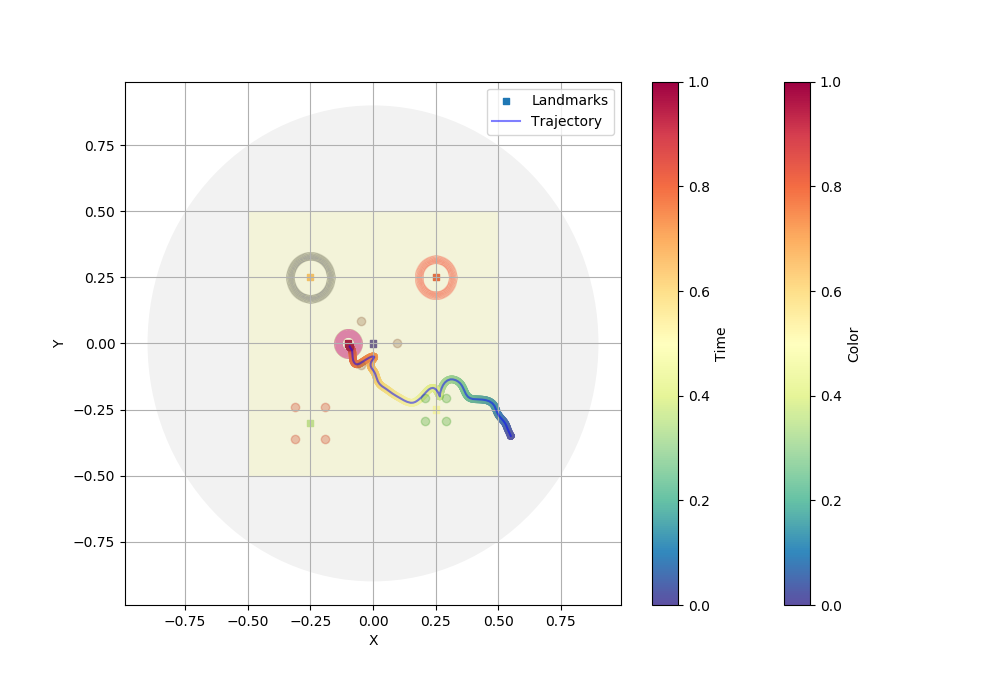

In [7]:
%matplotlib notebook

#Select trajectory number (based on number of videos )
traj_number = 180


# Print which fish and trial 
print("It's FISH " + trackFiles[traj_number][-12 : -10] + "   and TRIAL " +trackFiles[traj_number][-14 : -12])


# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 
fig, ax = plt.subplots()
circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.5,-0.5), 1.0, 1.0, alpha = 0.1, fc = 'yellow')


ax.add_patch(circ)
ax.add_patch(square)



plt.xlim(-1,1)
plt.ylim(-1,1)
# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax, marker = 's', style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r')
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax,c = 'Time', cmap = 'Spectral_r')

# Plotting masks to check 
plt.scatter(vertices_circles(traj_number, shapeData)[1][:,0],vertices_circles(traj_number, shapeData)[1][:,1], alpha=0.005)
plt.scatter(vertices_circles(traj_number, shapeData)[0][:,0],vertices_circles(traj_number, shapeData)[0][:,1], alpha=0.005)
plt.scatter(vertices_squares(traj_number, shapeData)[0][:,0],vertices_squares(traj_number, shapeData)[0][:,1], alpha = 0.3 )
plt.scatter(vertices_squares(traj_number, shapeData)[1][:,0],vertices_squares(traj_number, shapeData)[1][:,1], alpha = 0.3 )
plt.scatter(vertices_triangles(traj_number, shapeData)[0][:,0], vertices_triangles(traj_number, shapeData)[0][:,1], alpha = 0.3)
plt.scatter(vertices_triangles(traj_number, shapeData)[1][:,0], vertices_triangles(traj_number, shapeData)[1][:,1], alpha = 0.3)
plt.scatter(circle_around_food(traj_number, shapeData)[:,0], circle_around_food(traj_number, shapeData)[:,1], alpha = 0.003)

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.5, grid = True, figsize = (10,6.8), label = 'Trajectory')


plt.Axes.autoscale(ax)

# Late Learning Trials

In [8]:
early_end = 17
late_start = 64
late_end = 149 

In [89]:
fish_A_late = [] 
for i in range(late_start, late_end):
    if trackFiles[i][75] == 'A':
        fish_A_late.append(i)

In [90]:
time_list = []
for j in fish_A_late:
    pivot_list = [i *0.01 for i in range(0 , len(trackData[j]))]
    time_list.append(np.asarray(pivot_list))
    
normalized_time_list = []
for i in range(0,len(time_list)):
    normalized_time_list.append(time_list[i] / time_list[i][-1])

In [91]:
fish_A_late = [fish_A_late[0], fish_A_late[1]]

In [92]:
fish_A_late

[64, 65]

In [93]:
late_track_list = [trackData[i] for i in fish_A_late]
late_angle_list = [angleData[i] for i in fish_A_late]
late_posture_list = [postureData[i] for i in fish_A_late]

In [94]:
late_track_data  = pd.concat(late_track_list, ignore_index= True)
late_angle  = pd.DataFrame(np.concatenate(late_angle_list), columns= ['angle1', 'angle2', 'angle3', 'angle4'])
late_position  = pd.DataFrame(np.concatenate(late_posture_list), columns=  ["x1(m)", "y1(m)", "x2(m)", "y2(m)", "x3(m)", "y3(m)", "x4(m)", "y4(m)", "x5(m)", "y5(m)"])
late_time = pd.DataFrame(np.concatenate(normalized_time_list), columns = ["NormTime"])

late_angle['DistanceXEODPulse'] = late_track_data['DistanceXEODPulse']
late_position['DistanceXEODPulse'] = late_track_data['DistanceXEODPulse']
late_angle["NormTime"] = late_time["NormTime"]
late_position["NormTime"] = late_time["NormTime"]
# Removing zero values in DistanceXEODPulse -- they are associated with the starting and ending timeframe of recording 
late_angle  = late_angle[late_angle .DistanceXEODPulse != 0]
late_position  = late_position[late_position .DistanceXEODPulse != 0]
# Saving previous indices as a new columns because we're gonna filter data by keeping the last 15% of the trajectories
late_angle.reset_index(inplace=True)
late_position.reset_index(inplace =True)

late_position = late_position[late_position.NormTime >=0.85]
late_angle = late_angle[late_angle.NormTime >= 0.85]

In [95]:
len(late_angle) == len(late_position)

True

Even though SVD + K-Means worked pretty well for singular trajectories, here we have some problems. Let's try to use UMAP clustering and see what do we get ! 

## UMAP Embedding 
Try to get 3 dimensional space out of 4 dimensional angle-on-body based space

In [96]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster

In [97]:
clusterable_embedding_late = umap.UMAP(
    n_neighbors=100,
    min_dist=0.0,
    n_components=3,
    random_state= 137,
).fit_transform(late_angle.iloc[:,1:7].values)

C:\Users\jamesjun\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


### HDBSCAN on UMAP features 

In [102]:
labels_late = hdbscan.HDBSCAN(
    min_samples= 25,
    min_cluster_size= 20,
).fit_predict(clusterable_embedding_late)

<IPython.core.display.Javascript object>


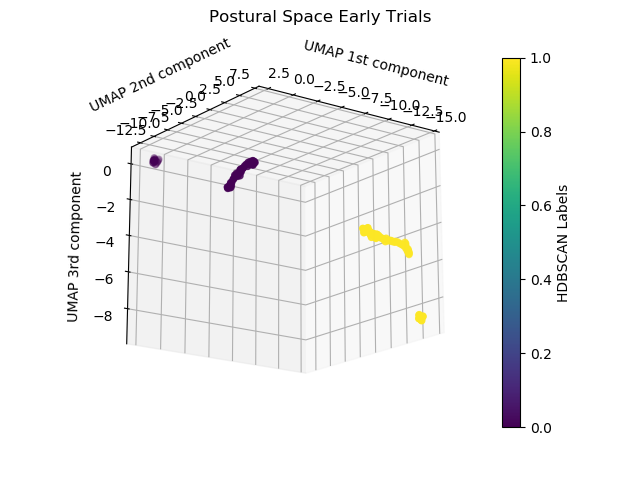

In [103]:
# In this way we exclude points labelled as "noise" == label 0 
clustered_late = (labels_late >= 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Postural Space Early Trials")

p = ax.scatter(clusterable_embedding_late[clustered_late,0], clusterable_embedding_late[clustered_late,1], clusterable_embedding_late[clustered_late,2], c = labels_late[clustered_late])#c = time/len(time))
ax.set_xlabel('UMAP 1st component')
ax.set_ylabel('UMAP 2nd component')
ax.set_zlabel('UMAP 3rd component')
cbar = fig.colorbar(p)
cbar.set_label("HDBSCAN Labels")

ax.view_init(elev = 0, azim = 0 )

plt.savefig("Images/Postural_Space_Early_Trials_UMAP_late.png")

<IPython.core.display.Javascript object>


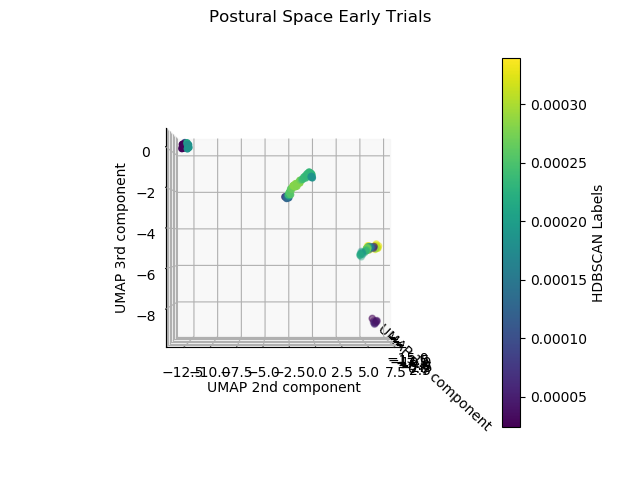

In [113]:
# In this way we exclude points labelled as "noise" == label 0 
clustered_late = (labels_late >= 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Postural Space Early Trials")

p = ax.scatter(clusterable_embedding_late[clustered_late,0], clusterable_embedding_late[clustered_late,1], clusterable_embedding_late[clustered_late,2], c = late_angle.iloc[clustered_late,5])#c = time/len(time))
ax.set_xlabel('UMAP 1st component')
ax.set_ylabel('UMAP 2nd component')
ax.set_zlabel('UMAP 3rd component')
cbar = fig.colorbar(p)
cbar.set_label("HDBSCAN Labels")

ax.view_init(elev = 0, azim = 0 )

#plt.savefig("Images/Postural_Space_Early_Trials_UMAP_late.png")

In [ ]:
# Exporting indices from HDBSCAN clustering procedure -- We've already filtered outliers in this way 
indices_label0 = np.argwhere(labels_fishA[clustered_fishA] == 0 ).flatten()
indices_label1 = np.argwhere(labels_fishA[clustered_fishA] == 1 ).flatten()
indices_label2 = np.argwhere(labels_fishA[clustered_fishA] == 2 ).flatten()

In [ ]:
early_amplitudes_fishA.iloc[indices_label0, :].hist(bins = 360)

In [ ]:
early_amplitudes_fishA.iloc[indices_label1, :].hist(bins = 360)

In [ ]:
early_amplitudes_fishA.iloc[indices_label2, :].hist(bins = 360)

In [ ]:
time_step = indices_label2[0]

In [ ]:
x = [early_position_fishA.iloc[time_step,0], early_position_fishA.iloc[time_step,2], early_position_fishA.iloc[time_step,4], early_position_fishA.iloc[time_step,6], early_position_fishA.iloc[time_step,8]]
x = np.asarray(x)

y = [early_position_fishA.iloc[time_step,1], early_position_fishA.iloc[time_step,3],early_position_fishA.iloc[time_step,5], early_position_fishA.iloc[time_step,7], early_position_fishA.iloc[time_step,9]]
y = np.asarray(y)

In [ ]:
tck = interpolate.splrep(x, y)
xnew = np.arange(x[0], x[-1], np.abs(x[0]/100))
ynew = interpolate.splev(xnew, tck, der=0)

In [ ]:
y

In [ ]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew,'b')
plt.legend(['James_Coordinates', 'Cubic Spline Posture'])
#plt.axis([0.1, 0.5, -1.05, 0])
plt.title('Fish Posture Reconstruction')
plt.show()
plt.savefig("Images/Posture_reconstruction.png")

### KMeans on UMAP features

In [107]:
from sklearn.cluster import KMeans 

In [116]:
kmeans_early_fishA = KMeans(n_clusters=6, random_state=137, n_jobs=8).fit(clusterable_embedding_late)

<IPython.core.display.Javascript object>


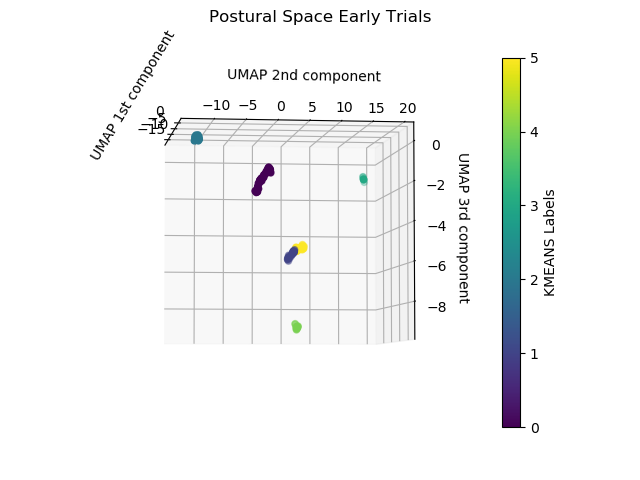

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Postural Space Early Trials")

p = ax.scatter(clusterable_embedding_late[:,0], clusterable_embedding_late[:,1], clusterable_embedding_late[:,2], c = kmeans_early_fishA.labels_)#c = time/len(time))
ax.set_xlabel('UMAP 1st component')
ax.set_ylabel('UMAP 2nd component')
ax.set_zlabel('UMAP 3rd component')
cbar = fig.colorbar(p)
cbar.set_label("KMEANS Labels")

ax.view_init(elev = 0, azim = 0 )

plt.savefig("Images/Postural_Space_Early_Trials_UMAP_KMEANS_fishA.png")

In [126]:
np.where( kmeans_early_fishA.labels_ == 2 )[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
       146, 147, 148, 149, 150, 151, 152, 153], dtype=int64)

In [127]:
np.where( kmeans_early_fishA.labels_ == 4 )[0]

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
      dtype=int64)

In [138]:
late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2 )[0][0],1]

0.010876

# Reconstruct the posture by spline fitting 

In [133]:
from scipy import interpolate

In [161]:
len(np.where(kmeans_early_fishA.labels_ == 3)[0])

11

In [183]:
x = [late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1] , late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1], late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1], late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1], late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],9]]
x = np.asarray(x)

y = [late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],2], late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],4],late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],6], late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1],late_position.iloc[np.where( kmeans_early_fishA.labels_ == 2)[0][1],1]]
y = np.asarray(y)

In [184]:
tck = interpolate.splrep(x, y)
xnew = np.arange(x[0], x[-1], np.abs(x[0]/50))
ynew = interpolate.splev(xnew, tck, der=0)

<IPython.core.display.Javascript object>


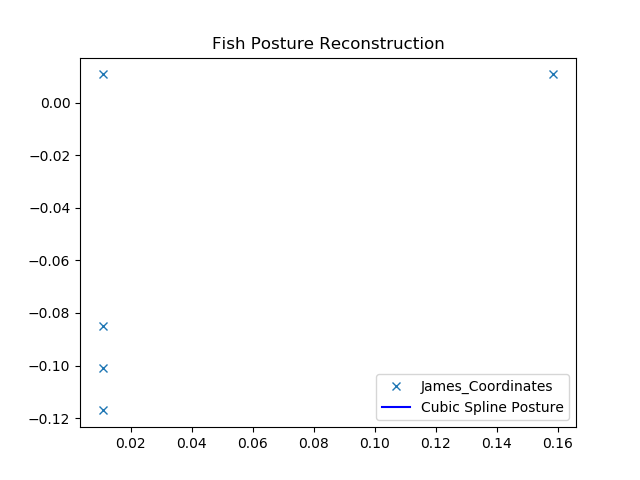

In [185]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew,'b')
plt.legend(['James_Coordinates', 'Cubic Spline Posture'])
#plt.axis([0.1, 0.5, -1.05, 0])
plt.title('Fish Posture Reconstruction')
plt.show()
plt.savefig("Images/Posture_reconstruction.png")